### Importing Necessary Packages

In [78]:
import pandas as pd
import os
from textblob import TextBlob
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Data Alignment

In [79]:
NEWS_FILE = '../data/raw_analyst_ratings.csv'
BASE_PATH = '../data/yfinance_data/'
STOCK_FILES = {
    'AAPL': 'AAPL_historical_data.csv',
    'AMZN': 'AMZN_historical_data.csv',
    'GOOG': 'GOOG_historical_data.csv',
    'META': 'META_historical_data.csv',
    'MSFT': 'MSFT_historical_data.csv',
    'NVDA': 'NVDA_historical_data.csv',
    'TSLA': 'TSLA_historical_data.csv'
}
news_data = pd.read_csv(NEWS_FILE)
stock_data_list = []
for ticker, file in STOCK_FILES.items():
    file_path = os.path.join(BASE_PATH, file)
    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        data['Stock'] = ticker
        stock_data_list.append(data)
    else:
        print(f"File not found: {file_path}")
stock_data = pd.concat(stock_data_list, ignore_index=True)
news_data['date'] = pd.to_datetime(news_data['date'], format='mixed', utc=True)
news_data['date'] = news_data['date'].dt.tz_convert('America/New_York').dt.date
news_data.rename(columns={'date': 'Date', 'stock': 'Stock'}, inplace=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
news_data = news_data[news_data['Stock'].isin(STOCK_FILES.keys())]
min_date = max(news_data['Date'].min(), stock_data['Date'].min())
max_date = min(news_data['Date'].max(), stock_data['Date'].max())
news_data = news_data[(news_data['Date'] >= min_date) & (news_data['Date'] <= max_date)]
stock_data = stock_data[(stock_data['Date'] >= min_date) & (stock_data['Date'] <= max_date)]
merged_data = pd.merge(news_data, stock_data, on=['Date', 'Stock'], how='left')
merged_data['Close'] = merged_data.groupby('Stock')['Close'].ffill()
merged_data = merged_data.dropna(subset=['Close'])
merged_data.to_csv('../data/merged_news_stock.csv', index=False)
merged_test = pd.read_csv('../data/merged_news_stock.csv')
merged_test.head()

,Unnamed: 0,headline,url,publisher,Date,Stock,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0
1,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0
2,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0
3,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0
4,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0


### Sentiment Analysis

In [80]:
news_data = pd.read_csv('../data/merged_news_stock.csv')
def get_sentiment(headline):
    return TextBlob(str(headline)).sentiment.polarity

news_data['Sentiment'] = news_data['headline'].apply(get_sentiment)
news_data.to_csv('../data/news_with_sentiment.csv', index=False)
test = pd.read_csv('../data/news_with_sentiment.csv')
test.head()

,Unnamed: 0,headline,url,publisher,Date,Stock,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sentiment
0,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.433333
1,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.000000
2,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.500000
3,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.000000
4,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.000000


### Calculate Daily Stock Returns

In [81]:
stock_data = pd.read_csv('../data/merged_news_stock.csv')
stock_data = stock_data.sort_values(['Stock', 'Date'])
stock_data['Daily_Return'] = stock_data.groupby('Stock')['Close'].pct_change() * 100
stock_data = stock_data.dropna(subset=['Daily_Return'])
stock_data.to_csv('../data/stock_with_returns.csv', index=False)
new_data = pd.read_csv('../data/stock_with_returns.csv')
news_data.head()

,Unnamed: 0,headline,url,publisher,Date,Stock,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sentiment
0,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.433333
1,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.000000
2,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.500000
3,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.000000
4,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10,AAPL,86.974998,88.692497,86.522499,88.209999,86.047615,166651600.0,0.0,0.0,0.000000


### Correlation Analysis

In [82]:
news_data = pd.read_csv('../data/news_with_sentiment.csv')
stock_data = pd.read_csv('../data/stock_with_returns.csv')
daily_sentiment = news_data.groupby(['Date', 'Stock'])['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'Sentiment': 'Avg_Sentiment'}, inplace=True)
daily_sentiment.to_csv('../data/daily_sentiment.csv', index=False)
analysis_data = pd.merge(daily_sentiment, stock_data[['Date', 'Stock', 'Daily_Return']], on=['Date', 'Stock'], how='inner')
analysis_data = analysis_data.dropna()
analysis_data.to_csv('../data/sentiment_returns.csv', index=False)
correlation_results = []
for stock in analysis_data['Stock'].unique():
    stock_data = analysis_data[analysis_data['Stock'] == stock]
    if len(stock_data) > 10:
        corr, p_value = pearsonr(stock_data['Avg_Sentiment'], stock_data['Daily_Return'])
        correlation_results.append({
            'Stock': stock,
            'Correlation': corr,
            'P_Value': p_value,
            'Sample_Size': len(stock_data)
        })
corr_data = pd.DataFrame(correlation_results)
corr_data.to_csv('../data/correlation_results.csv', index=False)
print(corr_data)

  Stock  Correlation   P_Value  Sample_Size
0  NVDA     0.048841  0.006152         3145
1  GOOG     0.018597  0.520192         1198
2  TSLA    -0.006335  0.784045         1874
3  AAPL     0.082001  0.085784          440
4  AMZN     0.113405  0.059433          277


### Visualization

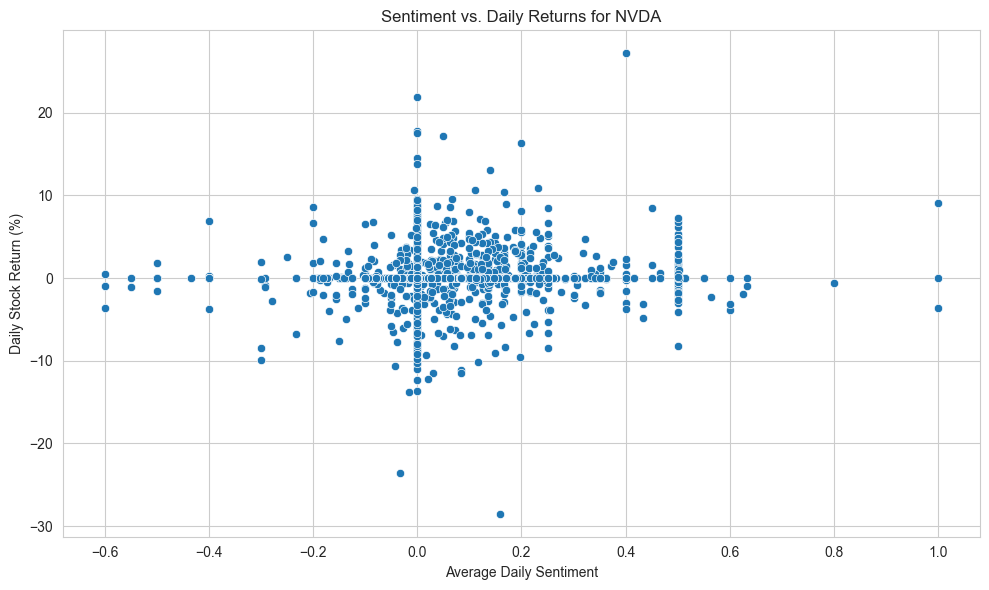

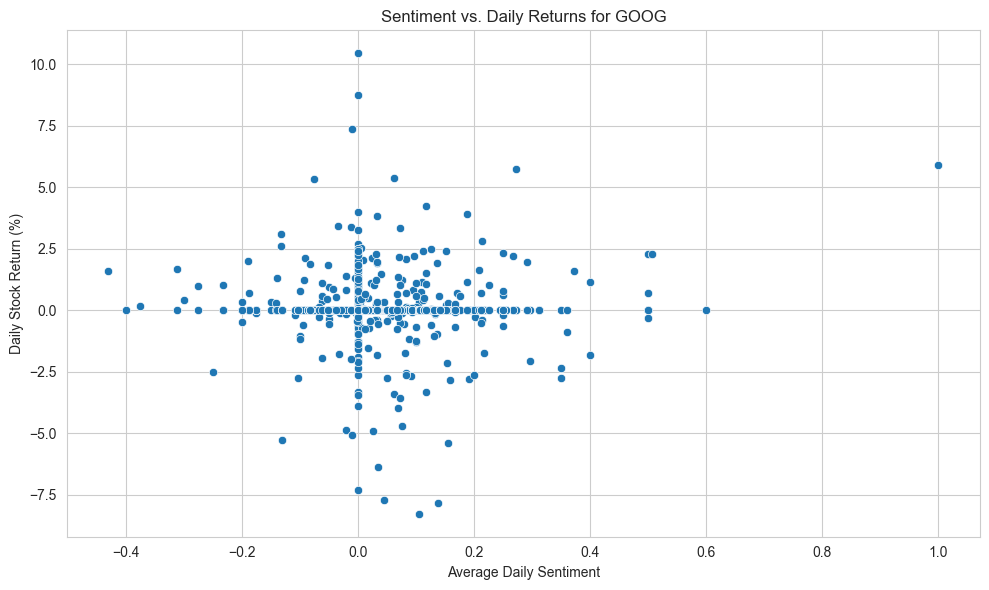

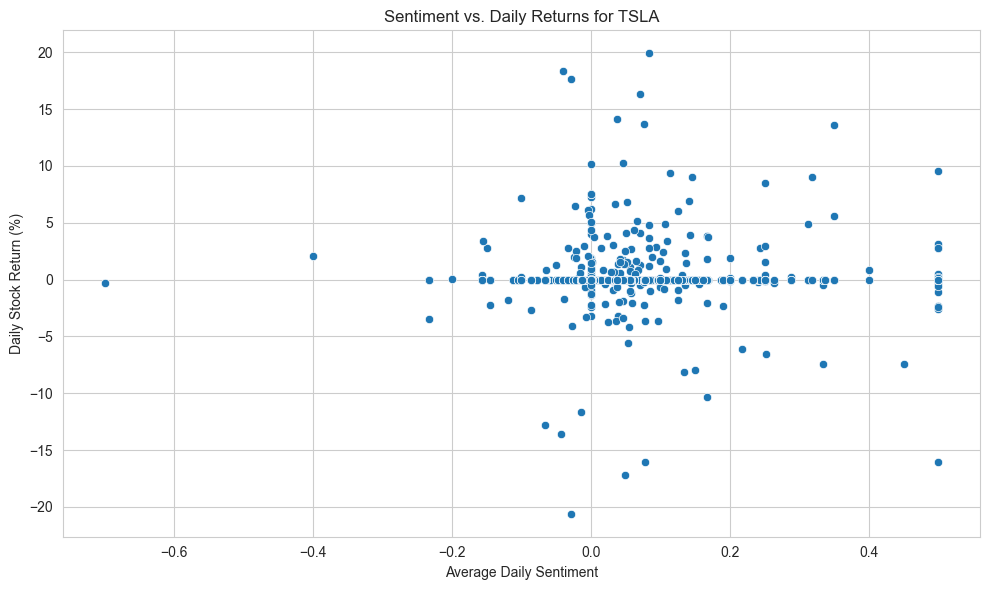

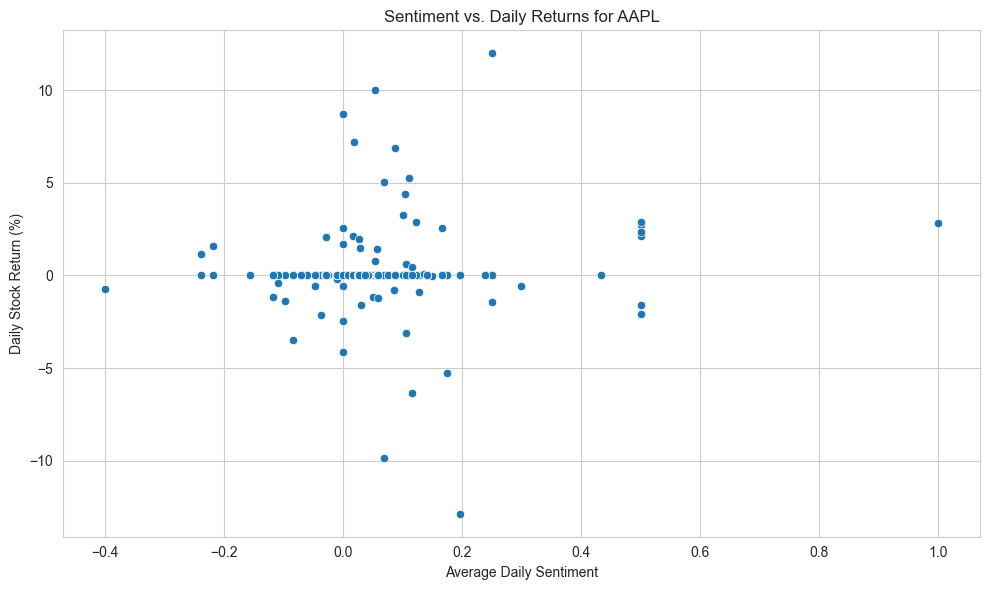

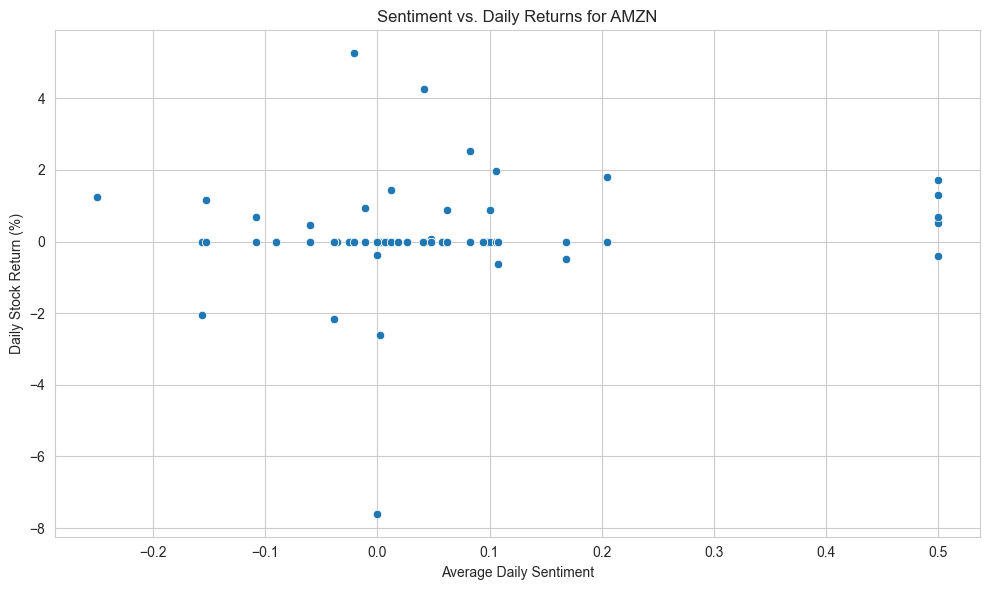

Correlation Pivot Table:
        Correlation
Stock             
AAPL      0.082001
AMZN      0.113405
GOOG      0.018597
NVDA      0.048841
TSLA     -0.006335


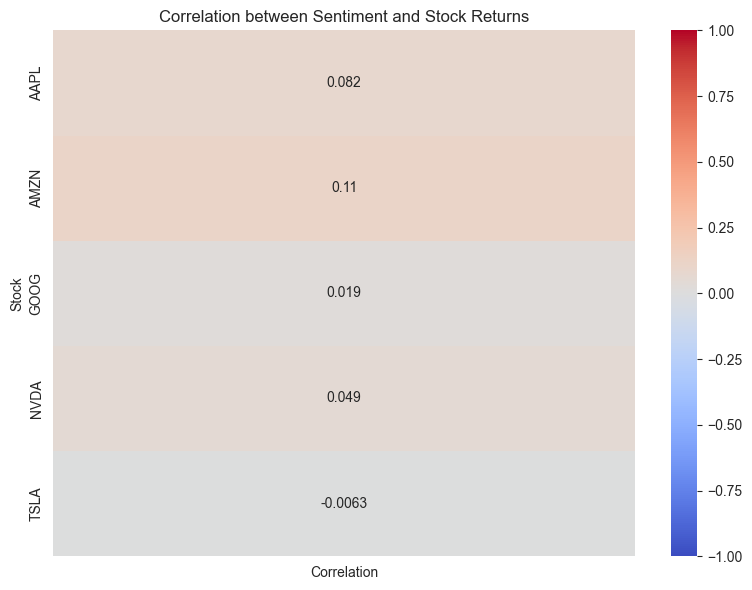

In [83]:
analysis_data = pd.read_csv('../data/sentiment_returns.csv')
corr_data = pd.read_csv('../data/correlation_results.csv')
for stock in analysis_data['Stock'].unique():
    stock_data = analysis_data[analysis_data['Stock'] == stock]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Avg_Sentiment', y='Daily_Return', data=stock_data)
    plt.title(f'Sentiment vs. Daily Returns for {stock}')
    plt.xlabel('Average Daily Sentiment')
    plt.ylabel('Daily Stock Return (%)')
    plt.tight_layout()
    plt.show()
corr_pivot = corr_data.pivot_table(index='Stock', values='Correlation')
print("Correlation Pivot Table:\n", corr_pivot)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_pivot, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation between Sentiment and Stock Returns')
plt.tight_layout()
plt.show()

Merged Data for Correlation Analysis Head:
        Date Stock  Avg_Sentiment  Daily_Return
0 2011-03-06  NVDA         -0.125     -1.349403
1 2011-03-06  NVDA         -0.125      0.000000
2 2011-03-07  NVDA          0.000      0.000000
3 2011-03-07  NVDA          0.000      0.000000
4 2011-03-07  NVDA          0.000      0.000000

Merged Data for Correlation Analysis Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6934 entries, 0 to 6933
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6934 non-null   datetime64[ns]
 1   Stock          6934 non-null   object        
 2   Avg_Sentiment  6934 non-null   float64       
 3   Daily_Return   6934 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 216.8+ KB

--- Correlation Analysis ---
Correlation for NVDA: 0.0488
Correlation for GOOG: 0.0186
Correlation for TSLA: -0.0063
Correlation for AAPL: 

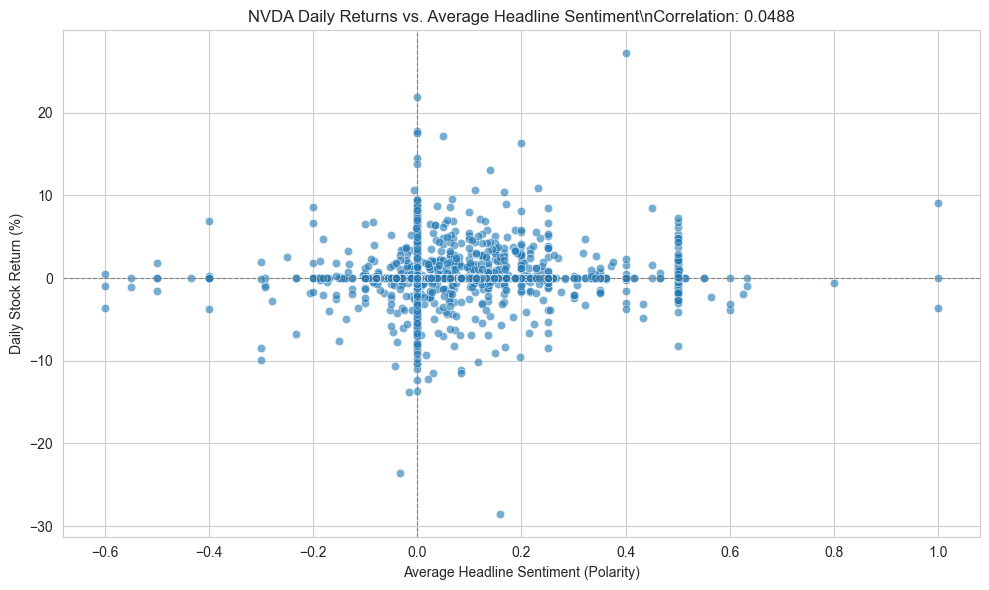

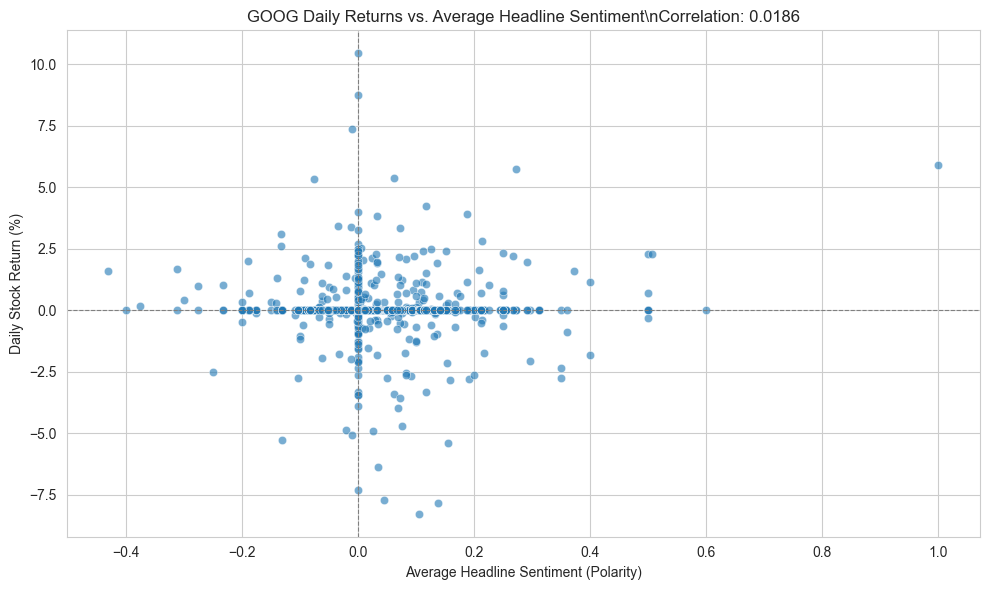

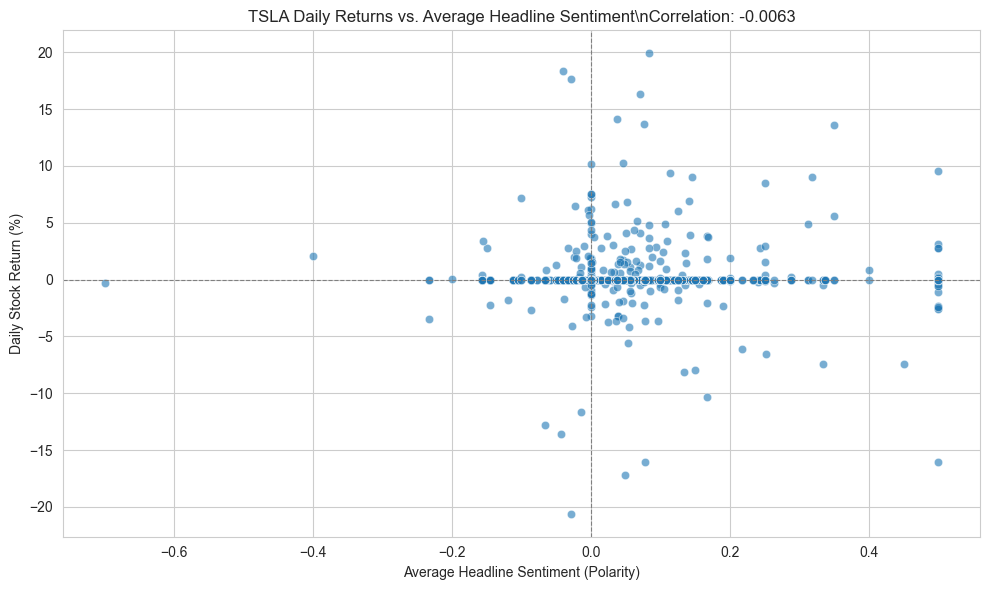

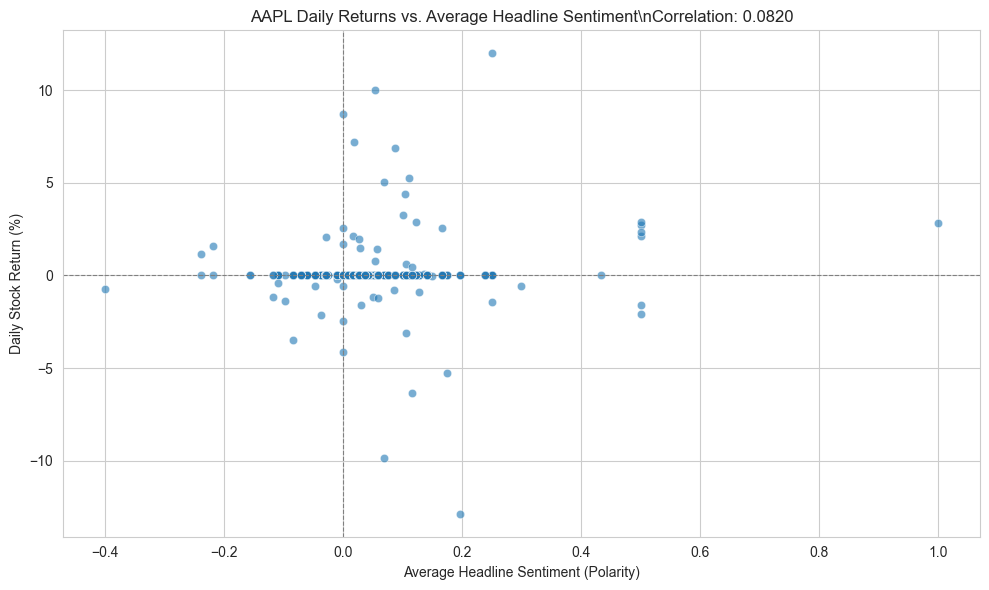

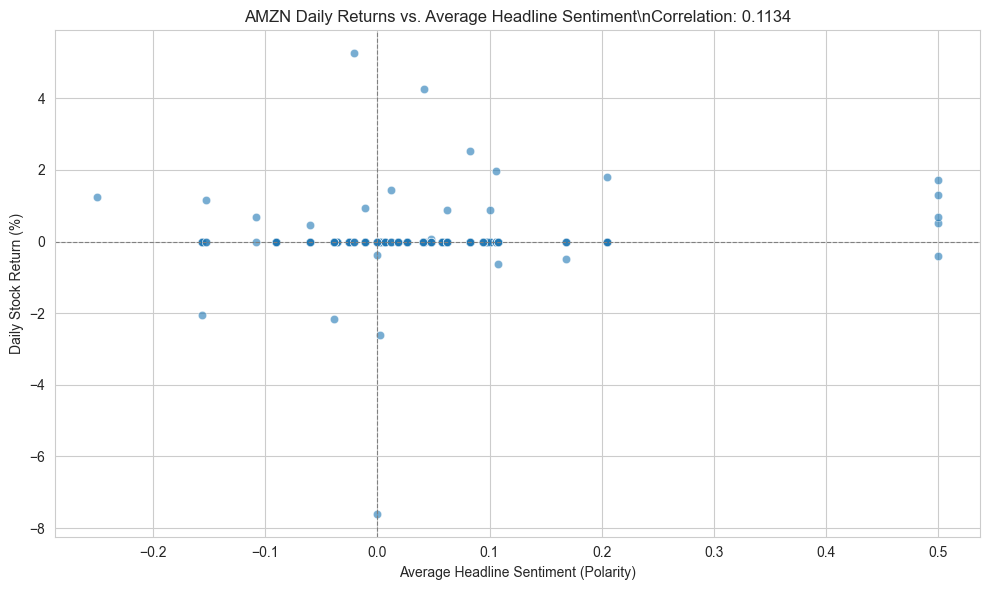


--- Summary of Correlation Results ---
NVDA: Pearson Correlation = 0.0488
GOOG: Pearson Correlation = 0.0186
TSLA: Pearson Correlation = -0.0063
AAPL: Pearson Correlation = 0.0820
AMZN: Pearson Correlation = 0.1134

--- Heatmap of Sentiment-Return Correlations ---


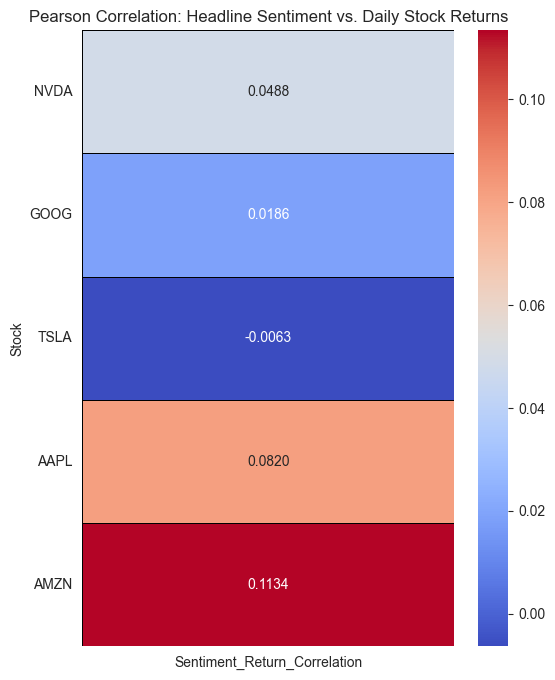

In [ ]:


try:
    news_with_sentiment = pd.read_csv('../data/news_with_sentiment.csv')
    stock_with_returns = pd.read_csv('../data/stock_with_returns.csv')
except FileNotFoundError:
    print("Ensure 'news_with_sentiment.csv' and 'stock_with_returns.csv' are in the '../data/' directory.")
    exit()

news_with_sentiment['Date'] = pd.to_datetime(news_with_sentiment['Date'])
stock_with_returns['Date'] = pd.to_datetime(stock_with_returns['Date'])

daily_sentiment = news_with_sentiment.groupby(['Date', 'Stock'])['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'Sentiment': 'Avg_Sentiment'}, inplace=True)

merged_analysis_data = pd.merge(daily_sentiment, stock_with_returns[['Date', 'Stock', 'Daily_Return']],
                                on=['Date', 'Stock'], how='inner')

merged_analysis_data.dropna(subset=['Daily_Return', 'Avg_Sentiment'], inplace=True)

print("Merged Data for Correlation Analysis Head:")
print(merged_analysis_data.head())
print("\nMerged Data for Correlation Analysis Info:")
merged_analysis_data.info()

correlation_results = {}
stocks = merged_analysis_data['Stock'].unique()

print("\n--- Correlation Analysis ---")
for stock in stocks:
    stock_df = merged_analysis_data[merged_analysis_data['Stock'] == stock]

    if len(stock_df) > 1:
        correlation, _ = pearsonr(stock_df['Avg_Sentiment'], stock_df['Daily_Return'])
        correlation_results[stock] = correlation
        print(f"Correlation for {stock}: {correlation:.4f}")
    else:
        correlation_results[stock] = np.nan
        print(f"Not enough data to calculate correlation for {stock}")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("\n--- Visualizations (Scatter Plots) ---")
for stock in stocks:
    stock_df = merged_analysis_data[merged_analysis_data['Stock'] == stock]

    if len(stock_df) > 1:
        plt.figure()
        sns.scatterplot(x='Avg_Sentiment', y='Daily_Return', data=stock_df, alpha=0.6)
        plt.title(f'{stock} Daily Returns vs. Average Headline Sentiment\\nCorrelation: {correlation_results[stock]:.4f}')
        plt.xlabel('Average Headline Sentiment (Polarity)')
        plt.ylabel('Daily Stock Return (%)')
        plt.grid(True)
        plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
        plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping scatter plot for {stock} due to insufficient data.")

print("\n--- Summary of Correlation Results ---")
for stock, corr in correlation_results.items():
    if not np.isnan(corr):
        print(f"{stock}: Pearson Correlation = {corr:.4f}")
    else:
        print(f"{stock}: Not enough data for correlation.")

print("\n--- Heatmap of Sentiment-Return Correlations ---")

corr_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Sentiment_Return_Correlation'])

corr_df.dropna(inplace=True)

if not corr_df.empty:
    plt.figure(figsize=(6, 8))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".4f", cbar=True,
                linewidths=.5, linecolor='black')
    plt.title('Pearson Correlation: Headline Sentiment vs. Daily Stock Returns')
    plt.ylabel('Stock')
    plt.yticks(rotation=0)
    plt.show()
else:
    print("No valid correlations to display in heatmap.")